# FORD A 데이터 설명

* 항목: 내용
* 데이터셋 이름: 	FordA (from UCR Archive)
* 목적: 	이진 분류 (증상이 존재한다 vs 존재하지 않는다)
* 샘플 수: 	예: 3601 (Train), 1320 (Test)
* 시계열 길이: 	500
* Feature 수: 	1 (엔진 소음 측정값)
* 클래스 라벨: 	0 또는 1
* 수집 환경: 	실제 엔진에서 수집, 잡음 적음

In [1]:
import torch
import pandas as pd
import numpy as np
import os
import time
import datetime

import datautils
import tasks
from ts2vec import TS2Vec

from utils import init_dl_program, name_with_datetime, pkl_save, data_dropout

In [2]:
from ts2vec import TS2Vec
import datautils

# Load the ECG200 dataset from UCR archive
train_data, train_labels, test_data, test_labels = datautils.load_UCR('FordA')
#/home/cksgh8511/ts2vec/datasets/UCR/UCRArchive_2018/FordA/FordA_TRAIN.tsv
# (Both train_data and test_data have a shape of n_instances x n_timestamps x n_features)



In [3]:
print(train_data.shape)
print(train_labels.shape)

(3601, 500, 1)
(3601,)


### Train label data
* 0이면: 이 500개의 시계열 전체가 정상 샘플
* 1이면: 이 시계열 전체가 증상이 있는 (이상) 샘플



In [4]:
train_labels_df = pd.DataFrame(train_labels)
train_labels_df

,0
0,0
1,1
2,0
3,0
4,0
...,...
3596,0
3597,1
3598,0
3599,1


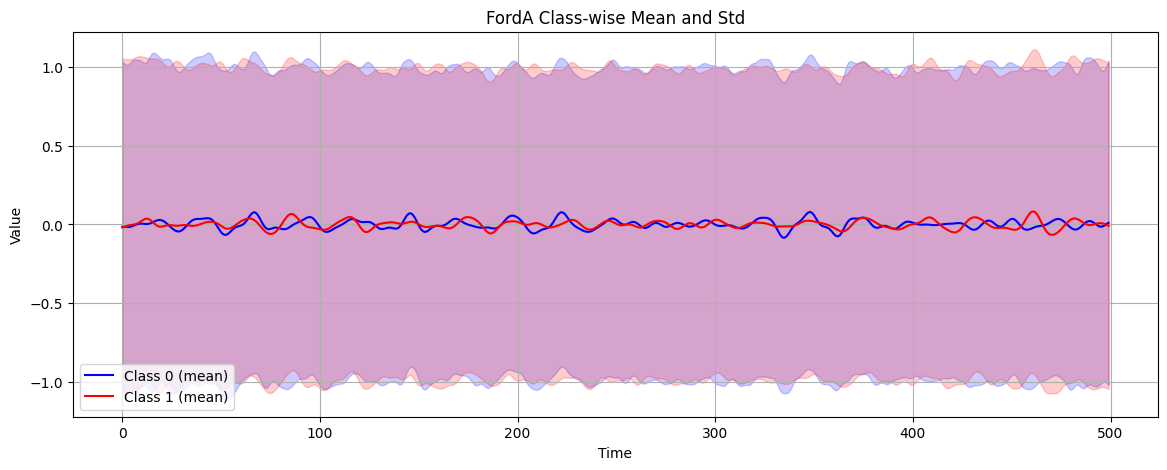

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 데이터 정리
class_0 = train_data[train_labels == 0].squeeze()  # shape: (n0, 500)
class_1 = train_data[train_labels == 1].squeeze()  # shape: (n1, 500)

mean_0 = class_0.mean(axis=0)
std_0 = class_0.std(axis=0)
mean_1 = class_1.mean(axis=0)
std_1 = class_1.std(axis=0)

# 시각화
plt.figure(figsize=(14, 5))
plt.plot(mean_0, label="Class 0 (mean)", color='blue')
plt.fill_between(np.arange(500), mean_0 - std_0, mean_0 + std_0, color='blue', alpha=0.2)

plt.plot(mean_1, label="Class 1 (mean)", color='red')
plt.fill_between(np.arange(500), mean_1 - std_1, mean_1 + std_1, color='red', alpha=0.2)

plt.title("FordA Class-wise Mean and Std")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

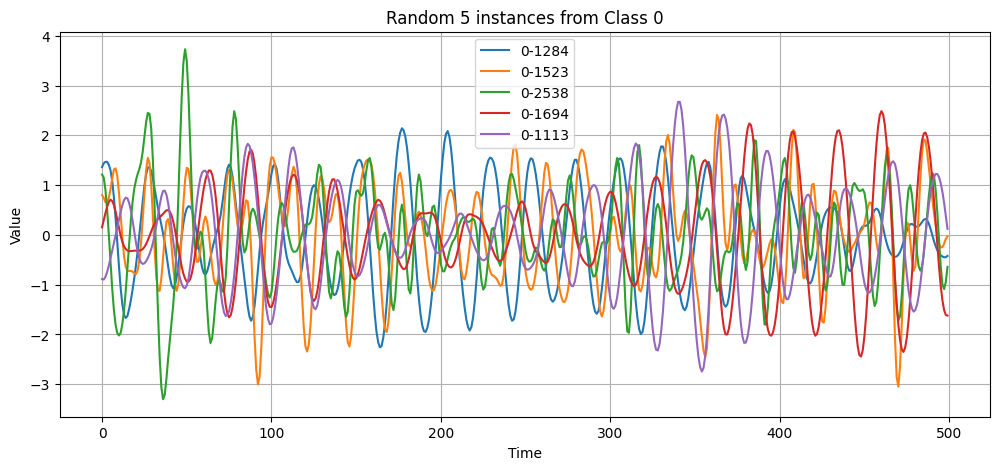

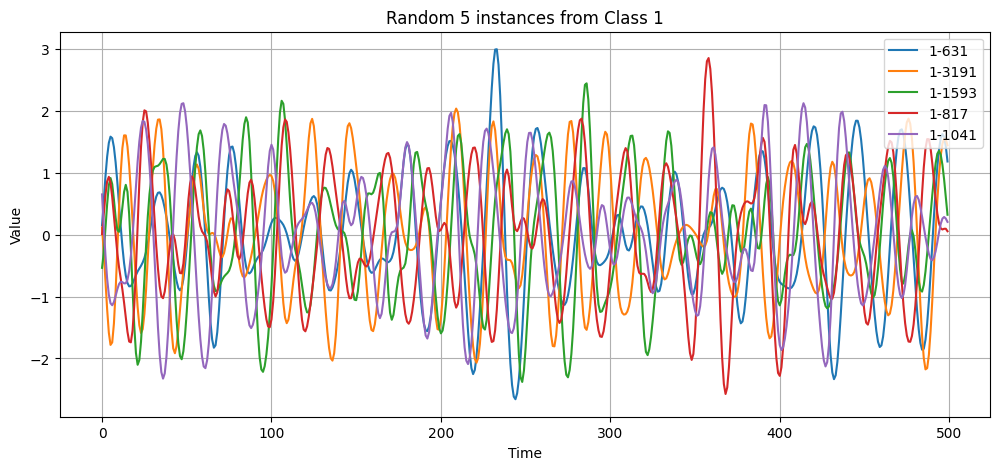

In [6]:
def plot_instances(data, labels, n=5, class_id=1):
    plt.figure(figsize=(12, 5))
    for i in range(n):
        idx = np.random.choice(np.where(labels == class_id)[0])
        plt.plot(data[idx].squeeze(), label=f'{class_id}-{idx}')
    plt.title(f'Random {n} instances from Class {class_id}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_instances(train_data, train_labels, n=5, class_id=0)
plot_instances(train_data, train_labels, n=5, class_id=1)

# 학습 목적

## eval_anomaly_detection

* 해당 파일은 이상이 있음 없음을 구분하는 데이터이지만, 이상치 탐지에 self - supervised train 방식으로 학습됩니다.
* Data 수집 방법 : train, test data를 flat시켜서 (train: 1800500 rows × 1 columns)으로 생성
* 학습 방법: Ts2vec의 loss 책정 방식처럼, 한 cropping된 단위에서 나온 데이터에 대해서 같은 시간은 positivie pair로 서로다른 instance나 다른 시간에 대해서는 negative로  책정합니다.
* test 방법: test데이터에 대해서 사전에 학습된 모델로 loss 추출해서 모델 성능 파악 예정
(해당 부분이 지금 문제임)

* 목표 : FordA로 pretrained된 TS2Vec 모델을 사용해서 내가 가지고 있는 테스트 시계열 데이터의 이상 구간을 탐지하고 평가하고 싶은 것.




In [7]:
train_data_flat = train_data.reshape(-1, 1)   # (3601*500, 1)
test_data_flat = test_data.reshape(-1, 1)

In [8]:
train_df = pd.DataFrame(train_data_flat)
train_df

,0
0,-0.797172
1,-0.664392
2,-0.373015
3,0.040815
4,0.526936
...,...
1800495,0.497019
1800496,0.527725
1800497,0.555761
1800498,0.574451


In [9]:
train_labels.shape

(3601,)

# Anomaly_detection 모델 

## Anomaly_detection.get_range_proba ()

- 일반적인 point-wise precision/recall은 아래 같은 문제를 가짐

* 한 anomaly 구간의 1초만 맞추면 TP로 계산됨 (과대평가)

* 여러 번 감지한 것을 TP로 중복 인정 (정밀도 왜곡)

* 반대로 조금 늦게 감지했더니 FN 처리됨 (과소평가)

#### => 그래서 range-based 평가 방식에서는 이런 식의 보정을 해줘야 공정한 성능 측정이 가능함.


## eval_anomaly_detection

* 목표: TS2Vec은 시계열의 representation을 만들 때, 특정 시점 t의 representation을 "그 이전 정보만 보고" 예측하게 만듭니다.

* 방식
    * sliding_length=1, causal=True, sliding_padding=200이라고 하면,
    * 한 번에 1 timestep씩 이동하면서
    * 각 시점 t에서 [t - padding, t - 1]까지의 데이터만을 context로 사용
    * mask_last : 해당 방식을 통해서 앞에서 만든 t - padding, t-1까지 데이터를 만들고, 마지막 t-1시점에 mask를 씌워 xt-1과 유사한지를 판독하게 만듬.


* 정상적인 시계열이라면 예측한 representation과 실제 representation이 거의 일치
* 이상이 발생한 시점은 예측하기 어려우므로 둘의 임베딩 차이가 커짐 → 큰 error 발생



In [10]:
'''
원래 시계열이 아래와 같이 있을 때:
x₀  x₁  x₂  x₃  x₄  x₅  x₆  x₇

슬라이딩 윈도우 구성이 causal + mask='mask_last'이면:
윈도우 인덱스	입력 시퀀스	마스킹된 입력 (mask_last)	타깃 시점
t=3	[x₀ x₁ x₂ x₃]	[x₀ x₁ x₂ <MASK>]	x₃
t=4	[x₁ x₂ x₃ x₄]	[x₁ x₂ x₃ <MASK>]	x₄
t=5	[x₂ x₃ x₄ x₅]	[x₂ x₃ x₄ <MASK>]	x₅


이렇게 해서 모델은:

<MASK> 위치의 representation을 예측하는 문제를 반복적으로 풀게 됩니다.

결과적으로 시점 t의 representation은 그 이전 정보만 보고 추론된 것이 됩니다.



정상 시계열:
    예측:       ----->
    실제:       ----->
    error:         0.01 ~ 0.05 정도

이상 발생 시:
    예측:       ----->
    실제:       ---^^^--->
    error:        ↑↑↑↑↑ (0.5~1.0 이상)



'''



"\n원래 시계열이 아래와 같이 있을 때:\nx₀  x₁  x₂  x₃  x₄  x₅  x₆  x₇\n\n슬라이딩 윈도우 구성이 causal + mask='mask_last'이면:\n윈도우 인덱스\t입력 시퀀스\t마스킹된 입력 (mask_last)\t타깃 시점\nt=3\t[x₀ x₁ x₂ x₃]\t[x₀ x₁ x₂ <MASK>]\tx₃\nt=4\t[x₁ x₂ x₃ x₄]\t[x₁ x₂ x₃ <MASK>]\tx₄\nt=5\t[x₂ x₃ x₄ x₅]\t[x₂ x₃ x₄ <MASK>]\tx₅\n\n\n이렇게 해서 모델은:\n\n<MASK> 위치의 representation을 예측하는 문제를 반복적으로 풀게 됩니다.\n\n결과적으로 시점 t의 representation은 그 이전 정보만 보고 추론된 것이 됩니다.\n\n\n\n정상 시계열:\n    예측:       ----->\n    실제:       ----->\n    error:         0.01 ~ 0.05 정도\n\n이상 발생 시:\n    예측:       ----->\n    실제:       ---^^^--->\n    error:        ↑↑↑↑↑ (0.5~1.0 이상)\n\n\n\n"

### error
* 정상적인 시계열이면 context만으로도 해당 시점을 잘 예측할 수 있음 → low error
* 이상이 있는 시점은 context만 보고 예측하기 어렵기 때문에 → high error



In [11]:
'''

train_repr = model.encode(..., mask='mask_last')  # 예측 기반
train_repr_wom = model.encode(..., mask=None)     # 실제 관측 기반

error = np.abs(train_repr_wom - train_repr).sum(axis=1)


시계열 (단일 시점):

  Window [x₀ ... x₁₉₉]      →     마스킹된 입력 [x₀ ... x₁₉₈, <MASK>]
                          \     /
                      비교 대상
                          /     \
  Full input [x₀ ... x₁₉₉]     →     실제 representation

  → 차이 = anomaly score at t₁₉₉
'''

<>:1: SyntaxWarning: invalid escape sequence '\ '
<>:1: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_446215/303874865.py:1: SyntaxWarning: invalid escape sequence '\ '
  '''


"\n\ntrain_repr = model.encode(..., mask='mask_last')  # 예측 기반\ntrain_repr_wom = model.encode(..., mask=None)     # 실제 관측 기반\n\nerror = np.abs(train_repr_wom - train_repr).sum(axis=1)\n\n\n시계열 (단일 시점):\n\n  Window [x₀ ... x₁₉₉]      →     마스킹된 입력 [x₀ ... x₁₉₈, <MASK>]\n                          \\     /\n                      비교 대상\n                          /       Full input [x₀ ... x₁₉₉]     →     실제 representation\n\n  → 차이 = anomaly score at t₁₉₉\n"

In [ ]:
'''

model.fit(
    data,
    n_epochs=2,             # ← 기본값이 2
    batch_size=256,
    lr=0.001,
    sliding_length=1,
    sliding_padding=200,
    temporal_unit='auto',
    verbose=True
)

'''

In [34]:
# Train a TS2Vec model
model = TS2Vec(
    input_dims=1,
    device=0,
    output_dims=320
)
loss_log = model.fit(
    train_data,
    n_epochs=18, 
    verbose=True
)

Epoch #0: loss=2.061768948502011
Epoch #1: loss=0.6607314007812076
Epoch #2: loss=0.6041913258367114
Epoch #3: loss=0.4647759913073646
Epoch #4: loss=0.3730207908815808
Epoch #5: loss=0.36076627943250866
Epoch #6: loss=0.3167254152231746
Epoch #7: loss=0.2689712432358
Epoch #8: loss=0.27024747000800237
Epoch #9: loss=0.23428804962171448
Epoch #10: loss=0.18100371663769085
Epoch #11: loss=0.2370135793586572
Epoch #12: loss=0.1560423617064953
Epoch #13: loss=0.2821478036377165
Epoch #14: loss=0.16373430334859423
Epoch #15: loss=0.13393778024448288
Epoch #16: loss=0.19449698151813613
Epoch #17: loss=0.13078795750935873


In [35]:
import sys
sys.path.append('/home/cksgh8511/ts2vec')

from tasks import anomaly_detection
import importlib
importlib.reload(anomaly_detection)

<module 'tasks.anomaly_detection' from '/home/cksgh8511/ts2vec/tasks/anomaly_detection.py'>

# eval_anomaly_detection 데이터 변환

In [36]:
# 1. Flatten (3601, 500, 1) → (3601*500, 1)
train_data_flat = train_data.reshape(-1, 1)
test_data_flat = test_data.reshape(-1, 1)

# 2. 라벨을 per-instance → per-timestamp 라벨로 확장
train_labels_flat = np.repeat(train_labels, train_data.shape[1])  # (3601 * 500,)
test_labels_flat = np.repeat(test_labels, test_data.shape[1])     # (1320 * 500,)

# 3. 타임스탬프 생성
train_ts = np.arange(len(train_data_flat))
test_ts = np.arange(len(test_data_flat))

# 4. dict로 포장
all_train_data = {'FordA': train_data_flat}
all_train_labels = {'FordA': train_labels_flat}
all_train_timestamps = {'FordA': train_ts}

all_test_data = {'FordA': test_data_flat}
all_test_labels = {'FordA': test_labels_flat}
all_test_timestamps = {'FordA': test_ts}

In [37]:
from tasks.anomaly_detection import eval_anomaly_detection
res_log, eval_res = eval_anomaly_detection(
    model,
    all_train_data,
    all_train_labels,
    all_train_timestamps,
    all_test_data,
    all_test_labels,
    all_test_timestamps,
    delay=7
)




In [38]:
print(res_log, eval_res)

[array([1, 1, 1, ..., 0, 0, 0])] {'f1': 0.7655303605878812, 'precision': 0.9930090169210732, 'recall': 0.622848200312989, 'infer_time': 117.30249285697937}


# 실험 결과

* epoch
    * 2: [array([0, 0, 0, ..., 0, 0, 0])] {'f1': 0.36914742220536306, 'precision': 0.9891264308225439, 'recall': 0.2269170579029734, 'infer_time': 119.16805148124695}
    * 10 : [array([1, 0, 0, ..., 0, 0, 1])] {'f1': 0.6754160934924589, 'precision': 0.9930396122590285, 'recall': 0.5117370892018779, 'infer_time': 117.58955597877502}
    * 15 : [array([1, 0, 0, ..., 0, 0, 0])] {'f1': 0.6970963801797004, 'precision': 0.9939666514045937, 'recall': 0.5367762128325508, 'infer_time': 116.91718816757202}
    * 18 : [array([1, 1, 1, ..., 0, 0, 0])] {'f1': 0.7655303605878812, 'precision': 0.9930090169210732, 'recall': 0.622848200312989, 'infer_time': 117.30249285697937}
    * 30 : [array([1, 0, 0, ..., 0, 0, 0])] {'f1': 0.7517640162116157, 'precision': 0.9950556560922669, 'recall': 0.6040688575899843, 'infer_time': 116.92543816566467}
        * [array([1, 0, 0, ..., 0, 0, 0])] {'f1': 0.6748099250878185, 'precision': 0.9963386084267019, 'recall': 0.5101721439749609, 'infer_time': 116.58314967155457}

    

In [39]:
'''

Epoch #0: loss=2.3456917095184324
Epoch #1: loss=0.8188001272413465
Epoch #2: loss=0.5390502043565114
Epoch #3: loss=0.4918669227759043
Epoch #4: loss=0.42021249691645307
Epoch #5: loss=0.30690707878934015
Epoch #6: loss=0.29895315498113634
Epoch #7: loss=0.28505542433924147
Epoch #8: loss=0.26644970648818544
Epoch #9: loss=0.23214916985895898
Epoch #10: loss=0.2403391491042243
Epoch #11: loss=0.17983951456016964
Epoch #12: loss=0.1764370155500041
Epoch #13: loss=0.14405666775173612
Epoch #14: loss=0.18550330319338373
Epoch #15: loss=0.16310656755334801
Epoch #16: loss=0.1654078014691671
Epoch #17: loss=0.19418435075216822
Epoch #18: loss=0.09924799686504734
Epoch #19: loss=0.171554047829575
Epoch #20: loss=0.11403838607172172
Epoch #21: loss=0.09898060934825076
Epoch #22: loss=0.11093388297491603
Epoch #23: loss=0.2060914174053404
Epoch #24: loss=0.15784495273398028
Epoch #25: loss=0.09114760876529747
Epoch #26: loss=0.13190548544128736
Epoch #27: loss=0.11746367406100035
Epoch #28: loss=0.06963118034932349
Epoch #29: loss=0.14351804641799795
'''

'\n\nEpoch #0: loss=2.3456917095184324\nEpoch #1: loss=0.8188001272413465\nEpoch #2: loss=0.5390502043565114\nEpoch #3: loss=0.4918669227759043\nEpoch #4: loss=0.42021249691645307\nEpoch #5: loss=0.30690707878934015\nEpoch #6: loss=0.29895315498113634\nEpoch #7: loss=0.28505542433924147\nEpoch #8: loss=0.26644970648818544\nEpoch #9: loss=0.23214916985895898\nEpoch #10: loss=0.2403391491042243\nEpoch #11: loss=0.17983951456016964\nEpoch #12: loss=0.1764370155500041\nEpoch #13: loss=0.14405666775173612\nEpoch #14: loss=0.18550330319338373\nEpoch #15: loss=0.16310656755334801\nEpoch #16: loss=0.1654078014691671\nEpoch #17: loss=0.19418435075216822\nEpoch #18: loss=0.09924799686504734\nEpoch #19: loss=0.171554047829575\nEpoch #20: loss=0.11403838607172172\nEpoch #21: loss=0.09898060934825076\nEpoch #22: loss=0.11093388297491603\nEpoch #23: loss=0.2060914174053404\nEpoch #24: loss=0.15784495273398028\nEpoch #25: loss=0.09114760876529747\nEpoch #26: loss=0.13190548544128736\nEpoch #27: loss=